# Plots generated for Figure 3 of initial submission of "Targeting the LIF/LIFR autrocrine fibroblast circuit in systemic sclerosis" (Kamiya, Tran, Gao et al.)

## Figure 3. Spatial transcriptomic profiling of SSc-ILD lung reveals that LIF+ and LIFR+ expression coloclaizes with inflammatroy fibroblasts and myofibroblasts.

- Overview: Integrated Xenium (re)analysis of 3 SSc-ILD lung samples from the BWH-TXG cohort. Samples profiled with the Xenium lung panel with custom add-on genes targeting mainly fibroblast substates. SSc data were subsetted from main cohort and reanalyzed in the context of LIF and/or LIFR positive fibroblasts.

- Figure components:
    - (3A) UMAP visualization of coarse spatial niche types.
    - (3B, ED1C) Spatial distribution of coarse tissue niches in a representative SSc-ILD lung tissue.
    - (3C, ED1D) Spatial density maps of LIF+ and LIFR+ fibroblasts in a representative SSc-ILD lung.
    - (3D) Heatmaps show the log2fold-change of LIF+ and/or LIFR+ fibroblast observed to expected frequencies assuming statistical independence across spatial niche types in SSc-ILD lung tissues.
    - (3E) Heatmaps show the log2fold-change of LIF+ and/or LIFR+ fibroblast observed to expected frequencies assuming statistical independence across fine fibroblast cell types in SSc-ILD lung tissues.
    - (3F, ED2B) Spatial colocalization of LIF+LIFR(-) fibroblasts tested against all cell types (with LIF+LIFR(-) fibroblasts excluded from the cell types). 
    - (3G, ED2B) Spatial colocalization of LIF+LIFR+ fibroblasts tested against all cell types (with LIF+LIFR+ fibroblasts excluded from the cell types).
    - (3H) Spatial plots of a high-magnification field of view from a representative SSc-ILD lung section. Cell types, fibroblast subtypes, and selected fibroblast populations with LIF and LIFR transcripts indicated in black or bronze, with a magnified inset.
    - (ED1A) Heatmap of marker genes for coarse spatial niches.
    - (ED1B) Heatmap of marker cell types for coarse spatial niches. 

## Packages:

In [40]:
suppressPackageStartupMessages({
    library(Seurat)
    library(ggplot2)
    library(dplyr)
    library(tibble)
    library(data.table)
    library(purrr)
    library(forcats)
    library(ggthemes)
    library(sf)
    library(vroom)
    library(patchwork)
    library(ComplexHeatmap)
    library(circlize)
    library(scales)
    library(future)
    library(furrr)
    library(presto)
    library(singlecellmethods)
    library(lme4)
})

Sys.setenv(PROJ_LIB = "/PHShome/mpt34/.conda/envs/test/share/proj")

## Functions:

In [15]:
# Plotting utility functions
fig.size <- function(h=6,w=6){
    options(repr.plot.width = w, repr.plot.height = h)
    return(NULL)
}

generate_colors_tableau<-function (input_vec, verbose = FALSE) 
{
    #col_by_values <- levels(input_vec)
    col_by_values <- unique(input_vec)
    if (verbose) {
        message("Number of unique values: ", length(col_by_values))
    }
    if (length(col_by_values) < 10) 
        pal_name <- "Tableau 10"
    else pal_name <- "Tableau 20"
    if (verbose) 
        message("Palette chosen: ", pal_name)
    pal <- tableau_color_pal(pal_name)
    max_n <- attr(pal, "max_n")
    if (length(col_by_values) < max_n) {
        cols_plot <- tableau_color_pal(pal_name)(length(col_by_values))
        names(cols_plot) <- stringr::str_sort(col_by_values, numeric = TRUE)
    }
    else {
        cols_plot <- colorRampPalette(tableau_color_pal(pal_name)(max_n))(length(col_by_values))
        names(cols_plot) <- stringr::str_sort(col_by_values, numeric = TRUE)
    }
    return(cols_plot)
}

In [21]:
# Colocalization functions
coloc_one_type = function(index_type, adj, y, nperm = 100, max_dist=30, compartments=NULL, verbose=TRUE) {
  if (verbose) message(index_type)
  types = unique(y)
  i_index = which(y == index_type)
  i_shuffle = setdiff(seq_len(length(y)), i_index)
  ## for index type calculate the frequency that each type is a neighbor
  X = adj[i_index, ] %*% Matrix::sparse.model.matrix(~0+y) %>% as.matrix()
  colnames(X) = gsub('^y', '', colnames(X))
  freq = (colSums(X) / nrow(X))[types]

  freq_perm = map(seq_len(nperm), function(i) {
    set.seed(i)
    yperm = y
    if (is.null(compartments)) {
      yperm[i_shuffle] = sample(y[i_shuffle])
    } else {
      ## shuffle inside compartments, to preserve total composition within compartment
      .x = split(i_shuffle, compartments[i_shuffle]) %>%
        map(function(.i) {
          ## CAUTION: if .i is a single number, sample will interpret it as 1:.i
          if (length(.i) == 1) {
            res = .i
          } else {
            res = sample(.i) ## shuffle non-index cells inside hub
          }

          names(res) = .i
          return(res)
        }) %>%
        reduce(c)
      yperm[as.integer(names(.x))] <- y[.x]
    }

    X = adj[i_index, ] %*% Matrix::sparse.model.matrix(~0+yperm) %>% as.matrix() #%>% prop.table(1)
    colnames(X) = gsub('^yperm', '', colnames(X))
    (colSums(X) / nrow(X))[types]
  }) %>%
    purrr::reduce(rbind2)

  stats = tibble(
    type = types,
    freq,
    zscore = (freq - apply(freq_perm, 2, mean)) / apply(freq_perm, 2, sd),
    pval = exp(pnorm(-zscore, log.p = TRUE, lower.tail = TRUE)), ## one-tailed
    fdr = p.adjust(pval)
  ) %>%
    cbind(dplyr::rename(data.frame(t(apply(freq_perm, 2, quantile, c(.025, .975)))), q025 = `X2.5.`, q975 = `X97.5.`)) %>% ## 95% CI
    subset(type != index_type) %>%
    dplyr::mutate(index_type = index_type) %>%
    dplyr::select(index_type, type, everything()) %>%
    arrange(fdr)

  return(stats)
}


#' Coloc all types
#'
#' Calculates adj from cell spatial coordinates; iterates coloc one type across each cell type; aggregates statistics
#'
#' @param index_types Unique vector of cell type labels
#' @param coords Matrix of x and y spatial coordinates of cells
#' @param y Cell type label vector
#' @param nperm Number of permutations
#' @param nsteps Connectivity degree considered as neighbors
#' @param max_dist Maximum radius cutofffor neighbor assignment
#' @param compartments Vector specifying which randomization compartment each cell is in leaving NULL shuffles cell labels across all data
#' @param parallel Parallelize coloc one type calls with future
#' @param verbose Message index type
#'
#' @return Tibble of statistics for index type colocalizations across all index types
#' @export
#'
#' @examples
#' # coloc_all_types with dataframe coords
#' coloc_all_types(index_type = unique(obj$fine_type), coords = as.matrix(obj$x, obj$y), y = obj$fine_type, compartments = obj$fov, max_dist = 40)
#'
coloc_all_types = function(index_types, coords, y, nperm = 100, nsteps=1, max_dist=30, compartments=NULL, parallel=TRUE, verbose=TRUE) {
  if (parallel & length(index_types) > 1) {
    plan(multisession, workers = 8)
  } else {
    plan(sequential)
  }

  ## Define neighbors based on Delauney triangulation
  ## NOTE: max_dist only refers to directly adjacent neighbors
  adj = spatula::getSpatialNeighbors(coords, return_weights = TRUE)
  adj@x[adj@x > max_dist] = 0
  adj = Matrix::drop0(adj)
  adj@x = rep(1, length(adj@x))

  ## If nsteps>1, consider not only your adjacent neighbors
  ##   but also your neighbor's neighbors etc.
  if (nsteps > 1) {
    adj = adj + Matrix::Diagonal(n = nrow(adj)) ## add self
    for (iter in seq_len(nsteps - 1)) {
      adj = adj %*% adj
    }
    ## Ignore weights. Only care if cell is a neighbor or not
    adj@x = rep(1, length(adj@x))

    ## Remove self as neighbor
    adj = adj - Matrix::Diagonal(n = nrow(adj))
    adj = Matrix::drop0(adj)
  }

  index_types %>%
    future_map(coloc_one_type, adj, y, nperm, max_dist, compartments, verbose, .options = furrr::furrr_options(seed = 1)) %>%
    rbindlist()
}

In [32]:
# Presto GLM markers
get_markers <- function(counts, meta_data, cluster_colname, sample_colname) {
    meta_data$cluster <- meta_data[[cluster_colname]]
    meta_data$library <- meta_data[[sample_colname]]
    pb <- presto::collapse_counts(
        counts, meta_data, 
        c('library', 'cluster'), 
        min_cells_per_group = 10, 
        get_norm = TRUE
    )  
    # pb$meta_data$cluster <- paste0('C', pb$meta_data$cluster)

    print(system.time({
        suppressWarnings({
            presto_res <- presto.presto(
                y ~ 1 + (1|cluster) + (1|cluster:library) + (1|library) + offset(logUMI), 
                pb$meta_data, 
                pb$counts_mat,
                size_varname = 'logUMI', 
                effects_cov = c('cluster'),
                ncore = 20, 
                min_sigma = .05, 
                family = 'poisson',
                nsim = 1000
            ) 
        })
    })[["elapsed"]])
    #print()

    contrasts_mat <- make_contrast.presto(presto_res, 'cluster')
    effects_marginal <- contrasts.presto(presto_res, contrasts_mat, one_tailed = TRUE) %>% 
        dplyr::mutate(cluster = contrast) %>% 
        dplyr::mutate(
            ## convert stats to log2 for interpretability 
            logFC = sign(beta) * log2(exp(abs(beta))),
            SD = log2(exp(sigma)),
            zscore = logFC / SD
        ) %>% 
        dplyr::select(cluster, feature, logFC, SD, zscore, pvalue) %>% 
        arrange(pvalue)
    effects_marginal$fdr <- p.adjust(effects_marginal$pvalue, method = 'BH')
    return(effects_marginal)
}

## Load Data.

In [2]:
# Annotated xenium data. Xenium custom panel samples were integrated with harmony. 
# Cell type annotations are derived from reference based label transfer w/ matched single cell data as describe in ILD Atlas paper.
xen <- readRDS("/data/wei/txg_lung/xenium/custom_panel/processed_data/xen_custom_harm_71025.rds")

# Annotated niche data. Result for integrated annotation of tissue niche clusters with tessera in custom panel xenium samples. 
xen_aggs <-readRDS("/data/wei/txg_lung/xenium/custom_panel/processed_data/xen_prop_tessera_pts_seur_anno_v2_71126.rds")

# Baysor output with cell geomestries for representative sscILD sample high magnification spatial plots (H)
bs13 <- readRDS("/data/wei/txg_lung/xenium/custom_panel/BS13-E08539B15_annotated_xenium_seurat.rds")

# Baysor tx file
# read in tx file, subset tx of interest and clear large file from memory
bs13_tx <- vroom("/data/wei/txg_lung/xenium/custom_panel/transcripts.csv")
xlims <- c(0,2000)
ylims <- c(10000, 12000)
tx_filt <- bs13_tx %>%
    filter(between(x,xlims[1], xlims[2])) %>%
    filter(between(y,ylims[1], ylims[2])) %>%
    filter(gene %in%c("LIF", "LIFR"))
rm(bs13_tx)

Rows: 87509897 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): gene, ncv_color
dbl (9): tile, x, y, cell, molecule_id, prior_segmentation, confidence, clus...
lgl (1): is_noise

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Figure 3A. UMAP visualization of coarse spatial niche types.

In [3]:
# Data preprocessing and normalization
ssc_tiss <- c("BS08-FS0446B4", 'BS12-K58643', 'BS13-E08539B15')

# subset xenium single cell data and aggregated niche data to only consider ssc samples
xen <- subset(xen, subset = tissue %in% ssc_tiss)
tess <- subset(xen_aggs$obj, subset = tissue %in% ssc_tiss)

#tess <- subset(tess, subset = tissue != "BA22-T00018A4") # sample excluded due widespread detection of LIFR. Outlier.
tess <- NormalizeData(tess, scale.factor = median(tess@meta.data$nCount_RNA))

Normalizing layer: counts



In [4]:
# Color mapping
# map niche types to numbers for figure.
tess@meta.data$coarse_niche_type_num <- case_when(
    tess@meta.data$coarse_niche_type == "Alv_epi" ~ "0", 
    tess@meta.data$coarse_niche_type == "Alv_inflam" ~ "1", 
    tess@meta.data$coarse_niche_type == "Alv_vasc" ~ "2", 
    tess@meta.data$coarse_niche_type == "Aw_trans" ~ "3", 
    tess@meta.data$coarse_niche_type == "Imm_lym" ~ "4", 
    tess@meta.data$coarse_niche_type == "Imm_myl" ~ "5", 
    tess@meta.data$coarse_niche_type == "Imm_plasma" ~ "6", 
    tess@meta.data$coarse_niche_type == "Inter_inflam" ~ "7", 
    tess@meta.data$coarse_niche_type == "Inter_strom" ~ "8", 
    tess@meta.data$coarse_niche_type == "Large_vessel" ~ "9", 
    tess@meta.data$coarse_niche_type == "Lymphatic" ~ "10"
    ) %>% 
    as.factor() 

# generate color mappings
niche_cols <- generate_colors_tableau(unique(tess$coarse_niche_type))
niche_cols_num <- generate_colors_tableau(levels(tess$coarse_niche_type_num))

# switch colors for better visibility of Inter_inflam in figure
temp_val <- niche_cols['Inter_inflam']
niche_cols['Inter_inflam'] <- niche_cols['Lymphatic']
niche_cols['Lymphatic'] <- temp_val


temp_val_num <- niche_cols_num['7']
niche_cols_num['7'] <- niche_cols_num['10']
niche_cols_num['10'] <- temp_val_num

NULL

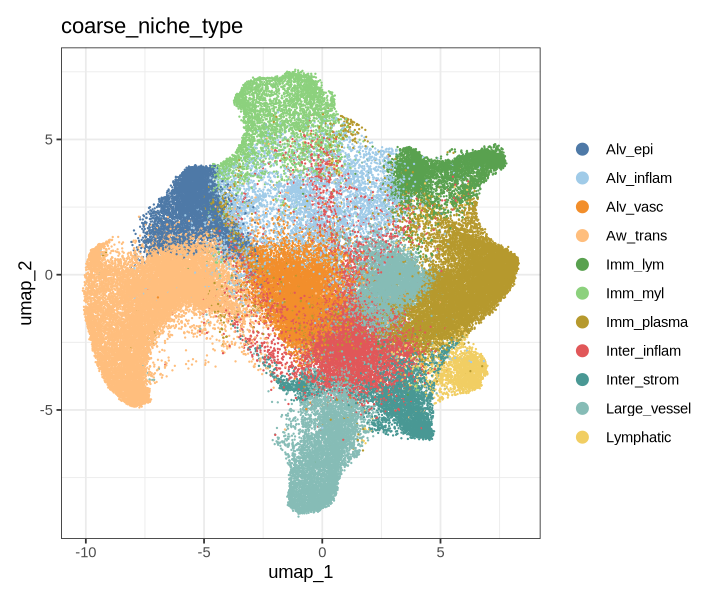

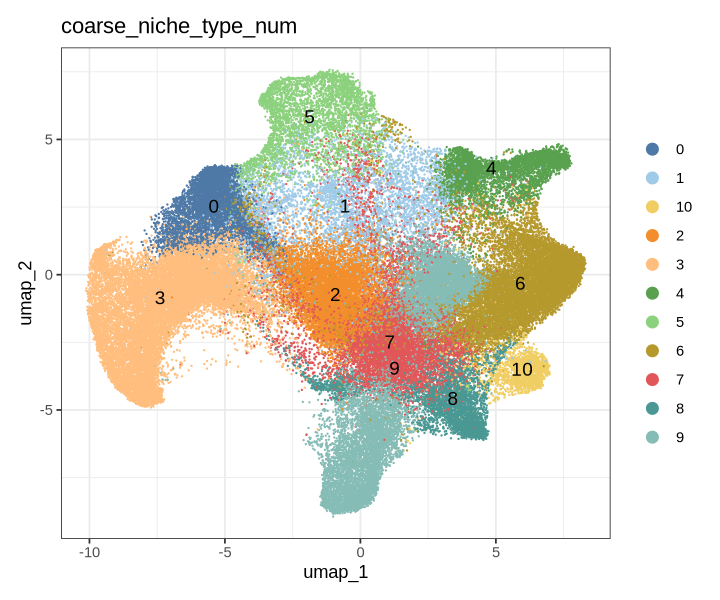

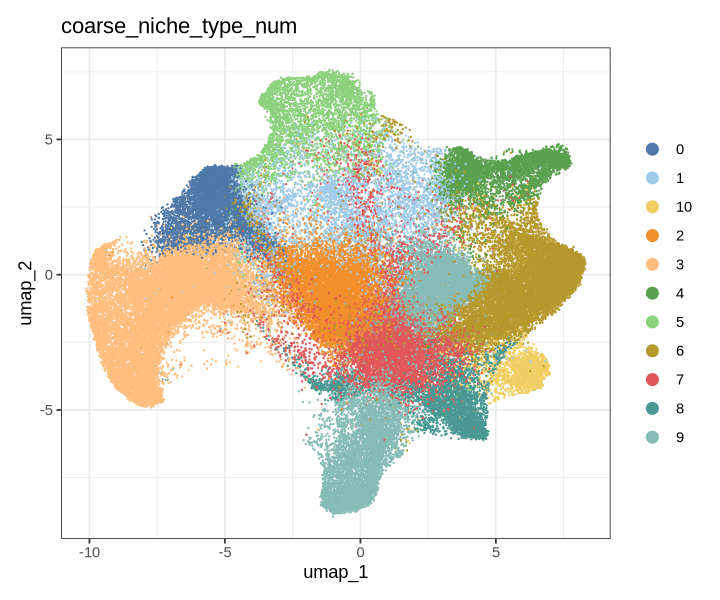

In [5]:
# Generate UMAPs for figure. Only SSc samples shown
fig.size(5,6)

DimPlot(subset(tess, subset = tissue %in% ssc_tiss), group.by= "coarse_niche_type", label =F)+
    theme_bw() +
    scale_color_manual(values= niche_cols)


DimPlot(subset(tess, subset = tissue %in% ssc_tiss), group.by= "coarse_niche_type_num", label =T)+
    theme_bw() +
    scale_color_manual(values= niche_cols_num)


DimPlot(subset(tess, subset = tissue %in% ssc_tiss), group.by= "coarse_niche_type_num", label =F)+
    theme_bw() +
    scale_color_manual(values= niche_cols_num)

## Definition of LIF/LIFR Fibroblasts in Xenium data.

In [6]:
# Extract LIF/LIFR expression
lif_lifr <- FetchData(xen, vars = c("LIF", "LIFR"), layer= "data")
xen@meta.data$lif <- lif_lifr$LIF
xen@meta.data$lifr <- lif_lifr$LIFR

#Threshold fibroblasts on detected expression of relevant genes
meta_temp <- xen@meta.data %>%
    mutate(lif_pos_fib = if_else(lif > 0 & coarse_ids == "Fibroblast", TRUE, FALSE)) %>%
    mutate(lifr_pos_fib = if_else(lifr > 0 & coarse_ids == "Fibroblast", TRUE, FALSE)) %>%
    mutate(tess_pt_id = paste0(tissue, "_", cell))
xen@meta.data <- meta_temp

# Propogate annotations to tessera object
tess_pts <- xen_aggs$pts %>%
    filter(tissue %in% ssc_tiss) %>%
    mutate(tess_pt_id = paste0(tissue, "_", ORIG_ID, "_xenium")) %>%
    left_join(dplyr::select(meta_temp, lif, lifr, lif_pos_fib, lifr_pos_fib, x,y, tissue), by = c("X"="x", "Y"="y", "tissue"="tissue"))

## Figure 3B. (Supp. 1C) Spatial distribution of coarse tissue niches in a representative SSc-ILD lung tissue.

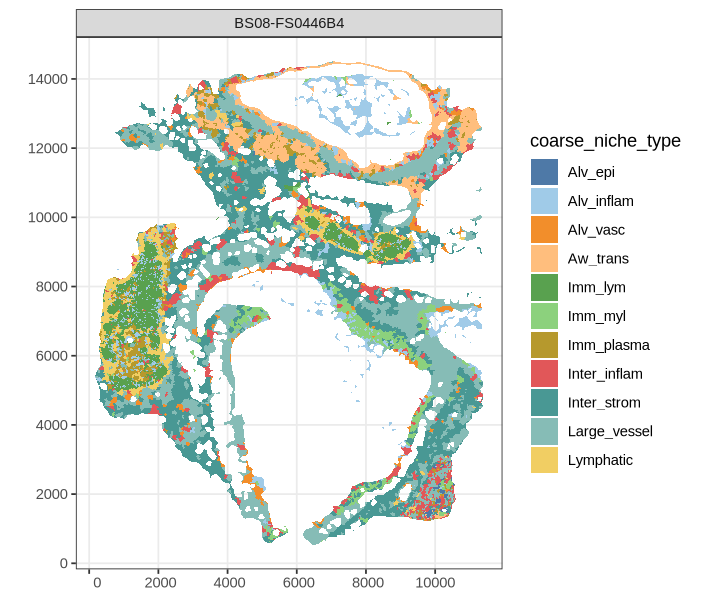

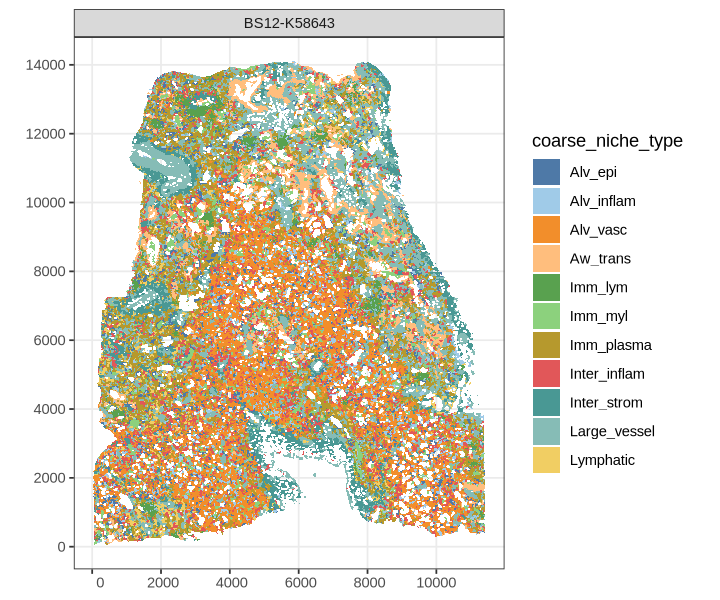

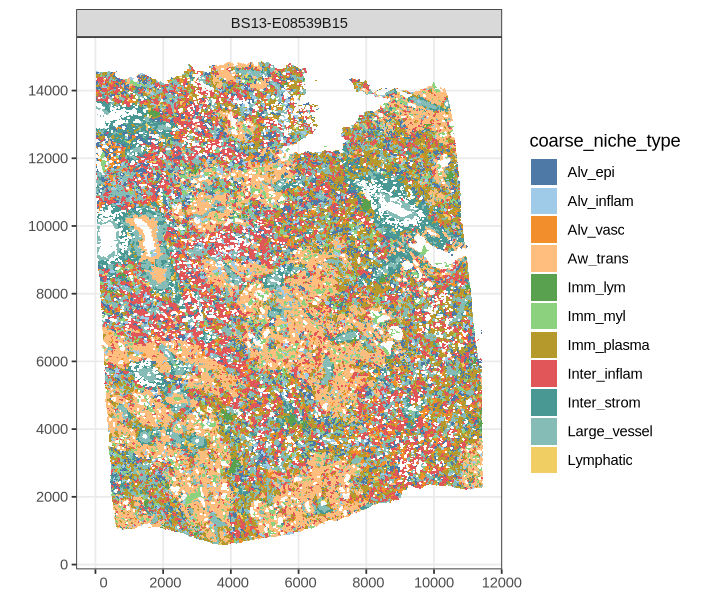

In [7]:
tess@meta.data %>%
    filter(tissue==ssc_tiss[1]) %>%
    ggplot() +
        geom_sf(aes(geometry = shape, fill = coarse_niche_type), col = NA)+
        theme_bw() +
        facet_wrap(~tissue, ncol = 3) +
        scale_fill_manual(values= niche_cols)

tess@meta.data %>%
    filter(tissue==ssc_tiss[2]) %>%
    ggplot() +
        geom_sf(aes(geometry = shape, fill = coarse_niche_type), col = NA)+
        theme_bw() +
        facet_wrap(~tissue, ncol = 3) +
        scale_fill_manual(values= niche_cols)

tess@meta.data %>%
    filter(tissue==ssc_tiss[3]) %>%
    ggplot() +
        geom_sf(aes(geometry = shape, fill = coarse_niche_type), col = NA)+
        theme_bw() +
        facet_wrap(~tissue, ncol = 3) +
        scale_fill_manual(values= niche_cols)

## Figure 3C (Supp. 1D). Spatial density maps of LIF+ and LIFR+ fibroblasts in a representative SSc-ILD lung.

NULL

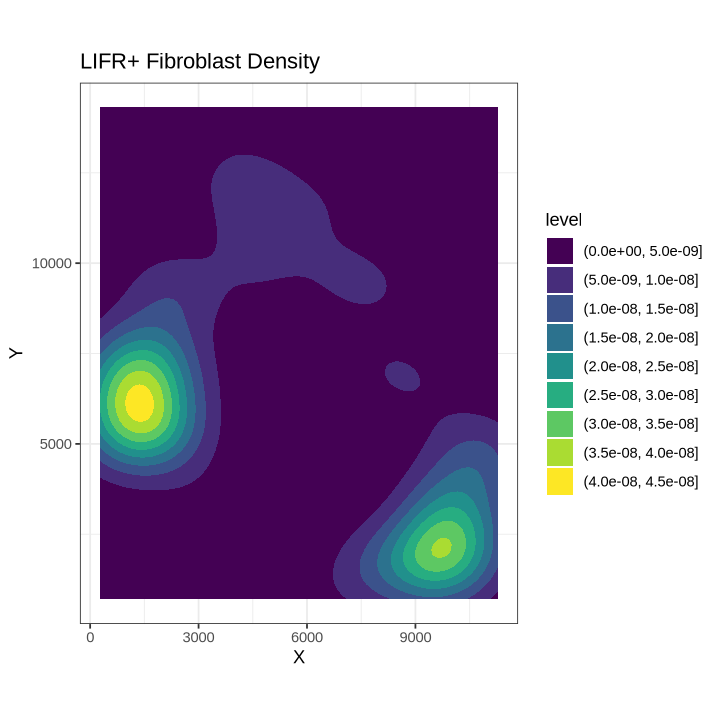

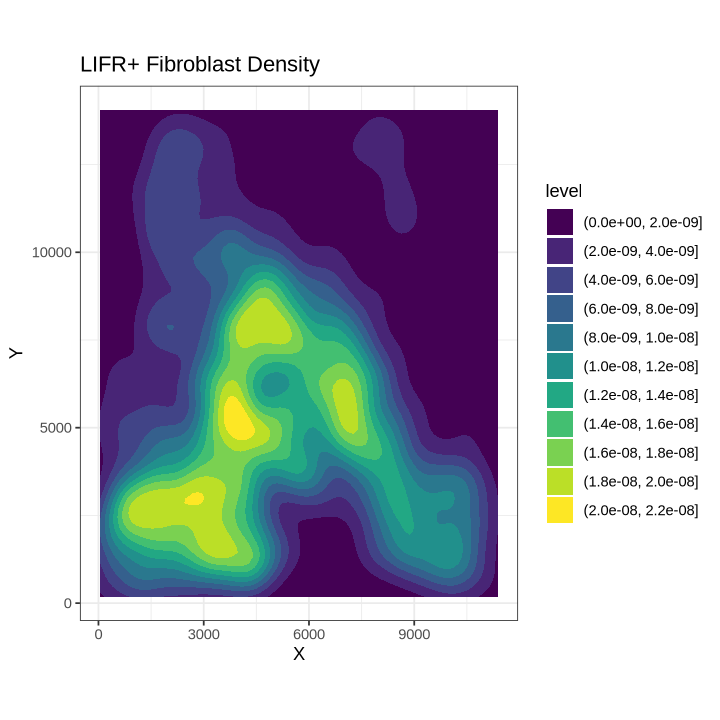

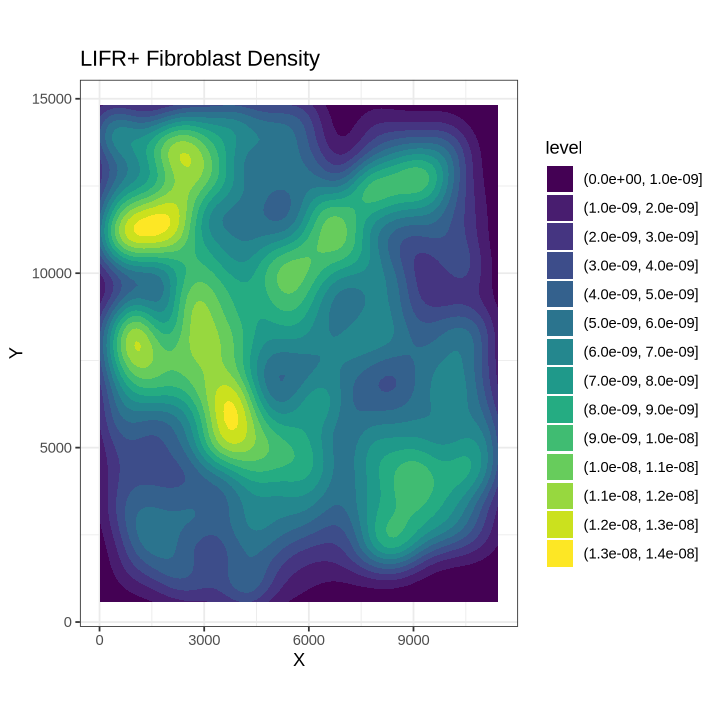

In [8]:
fig.size(6,6)
ggplot() +
    geom_density_2d_filled(data = tess_pts %>%
                           filter(tissue == ssc_tiss[1]) %>%
                           filter(lifr_pos_fib),
                           aes(X,Y, fill = after_stat(level)))+
    coord_fixed()+
    theme_bw() +
    ggtitle("LIFR+ Fibroblast Density")

ggplot() +
    geom_density_2d_filled(data = tess_pts %>%
                           filter(tissue == ssc_tiss[2]) %>%
                           filter(lifr_pos_fib),
                           aes(X,Y, fill = after_stat(level)))+
    coord_fixed()+
    theme_bw() +
    ggtitle("LIFR+ Fibroblast Density")

ggplot() +
    geom_density_2d_filled(data = tess_pts %>%
                           filter(tissue == ssc_tiss[3]) %>%
                           filter(lifr_pos_fib),
                           aes(X,Y, fill = after_stat(level)))+
    coord_fixed()+
    theme_bw() +
    ggtitle("LIFR+ Fibroblast Density")

## Figure 3D. Heatmaps show the log2fold-change of LIF+ and/or LIFR+ fibroblast observed to expected frequencies assuming statistical independence across spatial niche types in SSc-ILD lung tissues.

NULL

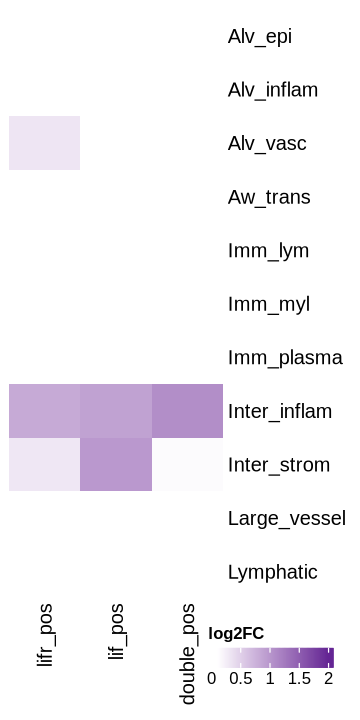

In [12]:
# assign each fibroblast a category based on lif/lifr positivity
ht_df <- tess_pts %>% 
    mutate(lif_lifr_type = case_when(
        lif_pos_fib & lifr_pos_fib ~ "double_pos",
        lif_pos_fib & !lifr_pos_fib ~ "lif_pos",
        !lif_pos_fib & lifr_pos_fib ~ "lifr_pos",
        !lif_pos_fib & !lifr_pos_fib ~ "double_neg",
    ))

# generate contingency table lif/lifr state and coarse niche type membership across cells
cont_tab <- table(ht_df$lif_lifr_type, ht_df$coarse_niche_type)

# generate heat map matrix of log2FC enrichment of lif/lifr fibroblast states across niche types
chi_sq_res <- chisq.test(cont_tab)
exp <- chi_sq_res$expected
obs <- chi_sq_res$observed %>% 
    as.data.frame() %>%
    pivot_wider(names_from=Var2, values_from = Freq) %>%
    column_to_rownames("Var1")

oe_heat_mat <- log(obs/exp,base = 2)

ht <- Heatmap(t(oe_heat_mat[-c(1), ]), show_heatmap_legend = F,cluster_rows = F,
            col = colorRamp2(c(0,0.5, 3), c("white" , "white",muted("purple"))), 
            name = "LogFC",
            cluster_columns = T,
            show_column_dend = F)

lgd <- Legend(title = "log2FC", direction = "horizontal", col_fun = colorRamp2(c(0,0.1, 2), c("white" , "white", muted("purple"))))

fig.size(6,3)
draw(ht)
draw(lgd, x = unit(0.75, "npc"), y = unit(0.05, "npc"), just = c("center", "bottom"))

## Figure 3E. Heatmaps show the log2fold-change of LIF+ and/or LIFR+ fibroblast observed to expected frequencies assuming statistical independence across fine fibroblast cell types in SSc-ILD lung tissues.

NULL

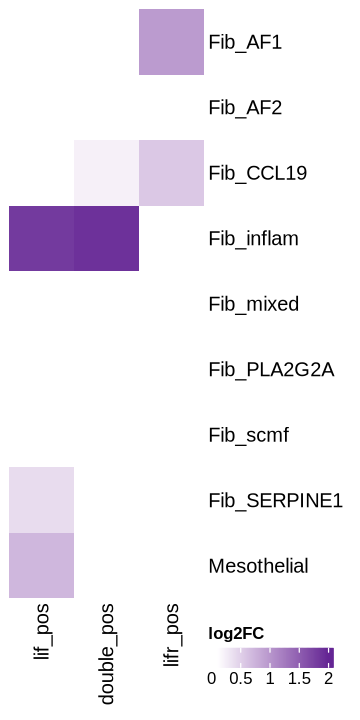

In [13]:
# Subset to only consider fibroblasts 
fib_df <- ht_df %>% 
    filter(coarse_ids == "Fibroblast")
# generate contingency table lif/lifr state and fine fiborblast type membership across cells
cont_tab_fib <- table(fib_df$lif_lifr_type, fib_df$merged_fine_ids)

# generate heat map matrix of log2FC enrichment of lif/lifr fibroblast states across fibroblast types
chi_sq_res_fib <- chisq.test(cont_tab_fib)
exp_fib <- chi_sq_res_fib$expected
obs_fib <- chi_sq_res_fib$observed %>% 
    as.data.frame() %>%
    pivot_wider(names_from=Var2, values_from = Freq) %>%
    column_to_rownames("Var1")
oe_heat_mat_fib <- log(obs_fib/exp_fib,base = 2)

ht_fib <- Heatmap(t(oe_heat_mat_fib[-c(1), ]), show_heatmap_legend = F,cluster_rows = F,
            col = colorRamp2(c(0,0.1, 2), c("white" , "white",muted("purple"))), 
            name = "LogFC",
            cluster_columns = T,
            show_column_dend = F)

lgd_fib <- Legend(title = "log2FC", direction = "horizontal", col_fun = colorRamp2(c(0,0.1, 2), c("white" , "white", muted("purple"))))

fig.size(6,3)
draw(ht_fib)
draw(lgd_fib, x = unit(0.75, "npc"), y = unit(0.05, "npc"), just = c("center", "bottom"))

## Xenium single cell permutation based colocalization analysis.

In [22]:
coloc_dat <- tess_pts %>%
    filter(tissue %in% ssc_tiss) %>%
    mutate(merged_fine_ids = case_when(
        lif_pos_fib & lifr_pos_fib ~ "lif_lifr_pos_fib",
        lif_pos_fib & !lifr_pos_fib ~ "lif_pos_fib",
        lifr_pos_fib & !lif_pos_fib ~ "lifr_pos_fib",
        .default = merged_fine_ids
    ))

In [31]:
t0 <- system.time({
    coloc_res <- coloc_all_types(index_types = unique(coloc_dat$merged_fine_ids), 
                            coords = as.matrix(coloc_dat[,c("X", "Y")]),
                            y = coloc_dat$merged_fine_ids,
                            max_dist = 100,
                            compartments = coloc_dat$tissue, parallel =T)
})

AT2

Cilliated

T_CD4_naive

Cap_aero

Plasma

Fib_AF2

preTRB_sc

Basal

T_stressed

Mu_peri

Arterial

Cap_gen

Venous_sys

B

Fib_AF1

lif_pos_fib

Neutrophil

Fib_inflam

Mu_VSMC

MacAlv

Fib_SERPINE1

lifr_pos_fib

MacInter_SPP1_APOE

Goblet

Fib_scmf

Venous_pb

Mu_ASMC

Mast_tryp

AT1

Fib_mixed

T_Tph

Mu_VSMC_NTRK3

T_CD8_GZMK

Mono_cDC2_DC_FCGBP

Mast

T_CD8

T_CD4_and_T_ifn_resp

MacInter

T_Treg

MacInter_CXCL10

B_naive

Lymphatic

Venous_pulm

AT0

NK_and_NK_immature

cDC1

AT1_immature

Fib_PLA2G2A

Basal_MMP1

mregDC

Club

T_CD4_memory

Fib_CCL19

Endo_SERPINE1

Mono

Endo_stress

Mono_neutro

Endo_mixed

lif_lifr_pos_fib

pDC

Mesothelial

Myl_stressed

Mixed_prolif

Mast_ADCYAP

T_CD8_CCL4

TRB_sc



## Figure 3F, 3G (Supp. 2B). (3F) Spatial colocalization of LIF+LIFR(-) fibroblasts tested against all cell types (with LIF+LIFR(-) fibroblasts excluded from the cell types). (3G) Spatial colocalization of LIF+LIFR+ fibroblasts tested against all cell types (with LIF+LIFR+ fibroblasts excluded from the cell types).

NULL

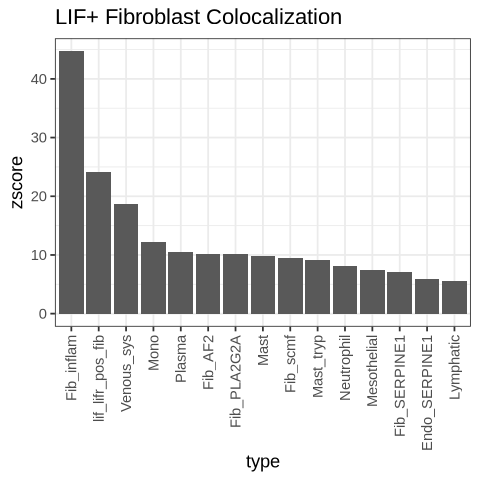

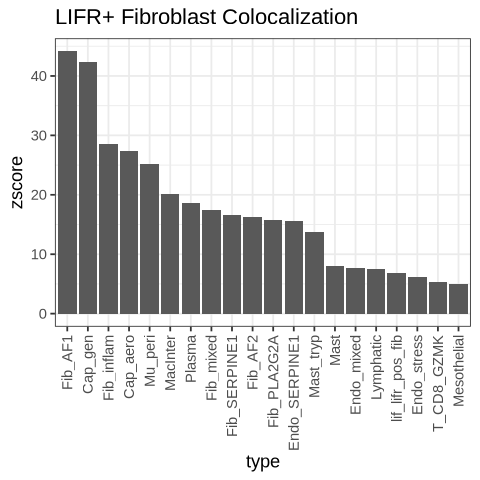

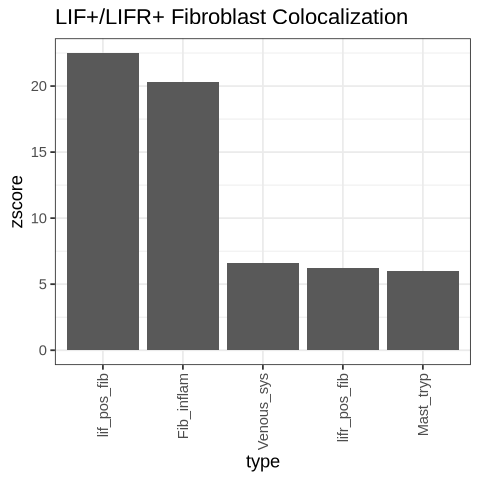

In [16]:
# Show only signifcant colocalizations
p1<- coloc_res %>% filter(index_type == "lif_pos_fib") %>%
    filter(zscore > 5, fdr < .01) %>%
    mutate(type = fct_reorder(type, -zscore)) %>%
    ggplot(aes(x = type, y= zscore))+
        geom_col() + 
        theme_bw()+
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
        ggtitle("LIF+ Fibroblast Colocalization")

p2 <- coloc_res %>% filter(index_type == "lifr_pos_fib") %>%
    filter(zscore > 5, fdr < .01) %>%
    mutate(type = fct_reorder(type, -zscore)) %>%
    ggplot(aes(x = type, y= zscore))+
        geom_col() + 
        theme_bw()+
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
        ggtitle("LIFR+ Fibroblast Colocalization")

p3 <- coloc_res %>% filter(index_type == "lif_lifr_pos_fib") %>%
    filter(zscore > 5, fdr < .01) %>%
    mutate(type = fct_reorder(type, -zscore)) %>%
    ggplot(aes(x = type, y= zscore))+
        geom_col() + 
        theme_bw()+
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
        ggtitle("LIF+/LIFR+ Fibroblast Colocalization")

fig.size(4,4)
p1
p2
p3

NULL

NULL

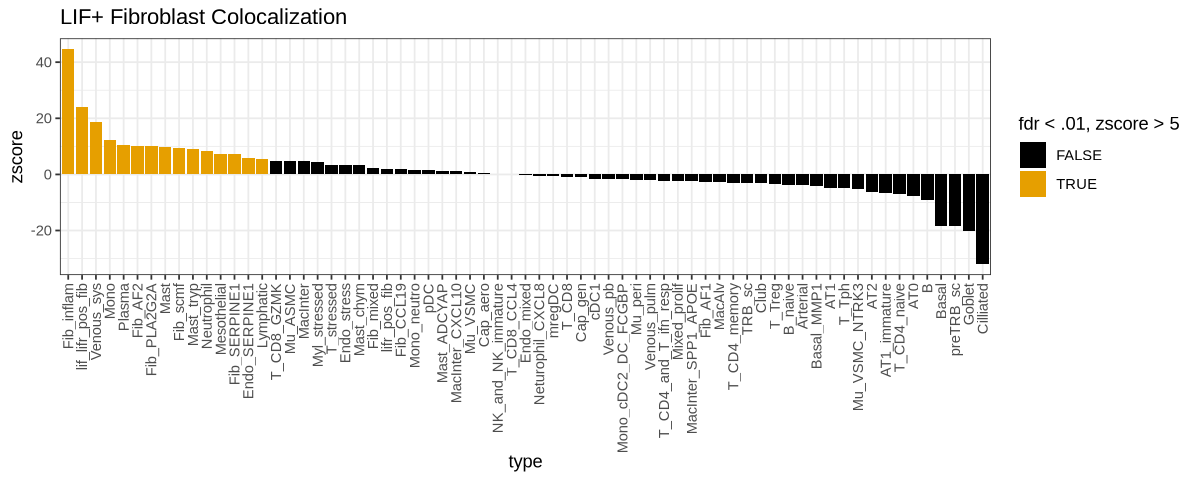

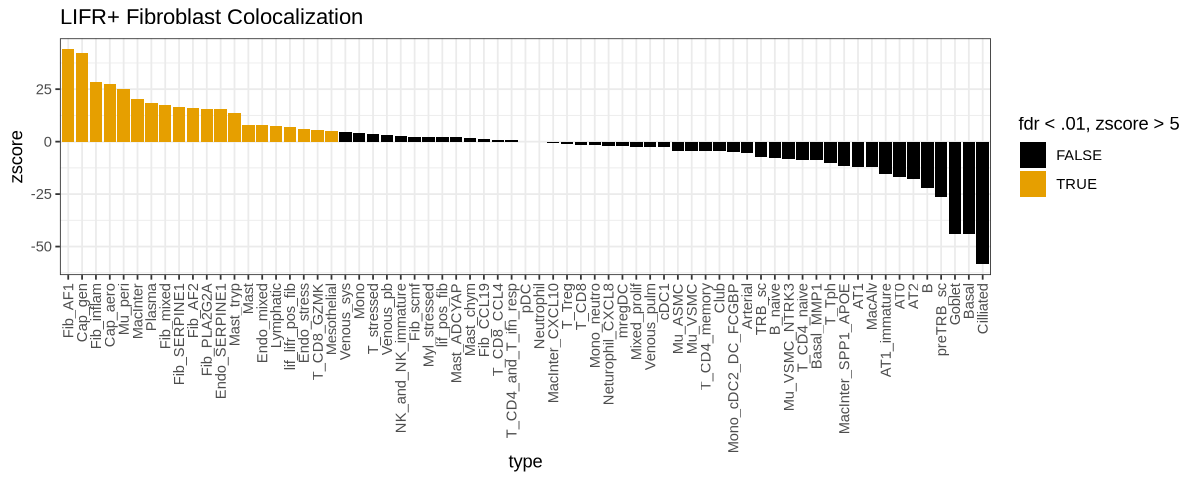

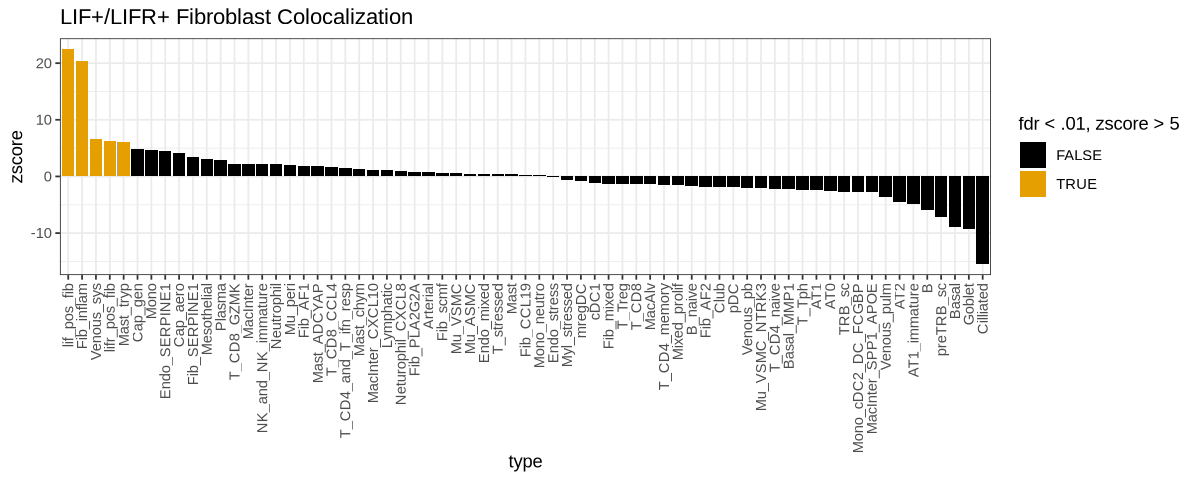

In [17]:
# Show significant colocalizations in context of all cell cell types
fig.size(4,4)
p1<- coloc_res %>% filter(index_type == "lif_pos_fib") %>%
    mutate(type = fct_reorder(type, -zscore)) %>%
    ggplot(aes(x = type, y= zscore, fill = zscore > 5, fdr < .01))+
        geom_col() + 
        theme_bw()+
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
        ggtitle("LIF+ Fibroblast Colocalization") + 
        scale_fill_colorblind(name = "fdr < .01, zscore > 5")

p2 <- coloc_res %>% filter(index_type == "lifr_pos_fib") %>%
    mutate(type = fct_reorder(type, -zscore)) %>%
    ggplot(aes(x = type, y= zscore, fill = zscore > 5, fdr < .01))+
        geom_col() + 
        theme_bw()+
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
        ggtitle("LIFR+ Fibroblast Colocalization")+
        scale_fill_colorblind(name = "fdr < .01, zscore > 5")

p3 <- coloc_res %>% filter(index_type == "lif_lifr_pos_fib") %>%
    mutate(type = fct_reorder(type, -zscore)) %>%
    ggplot(aes(x = type, y= zscore, fill = zscore > 5, fdr < .01))+
        geom_col() + 
        theme_bw()+
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
        ggtitle("LIF+/LIFR+ Fibroblast Colocalization")+

        scale_fill_colorblind(name = "fdr < .01, zscore > 5")

fig.size(4,10)
p1
p2
p3

## Figure 3H. Spatial plots of a high-magnification field of view from a representative SSc-ILD lung section. Cell types, fibroblast subtypes, and selected fibroblast populations with LIF and LIFR transcripts indicated in black or bronze, with a magnified inset.

In [18]:
# Append cell shapes to single cell metadata
bs13_tess_shapes <- tess_pts %>%
    filter(tissue =="BS13-E08539B15") %>%
    left_join(dplyr::select(bs13@meta.data, x, y, geometry), by = c("X"="x", "Y"="y"))

NULL

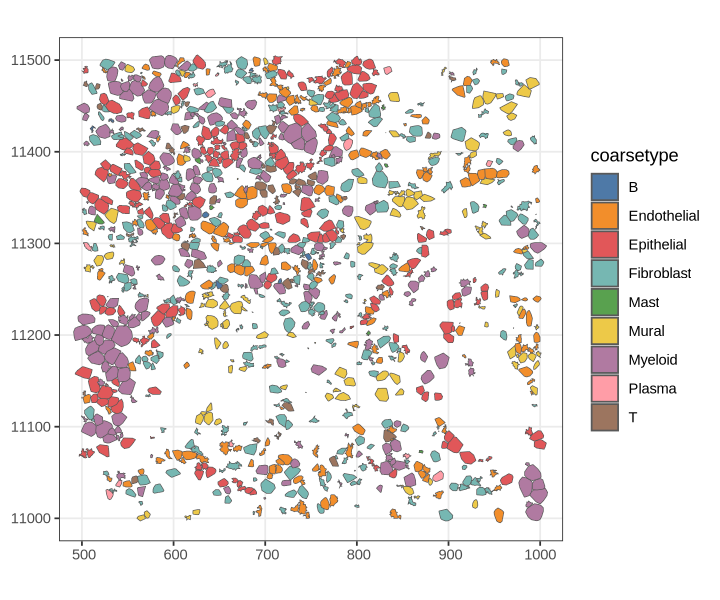

Warning message:
“Removed 9917 rows containing missing values or values outside the scale range
(`geom_point()`).”


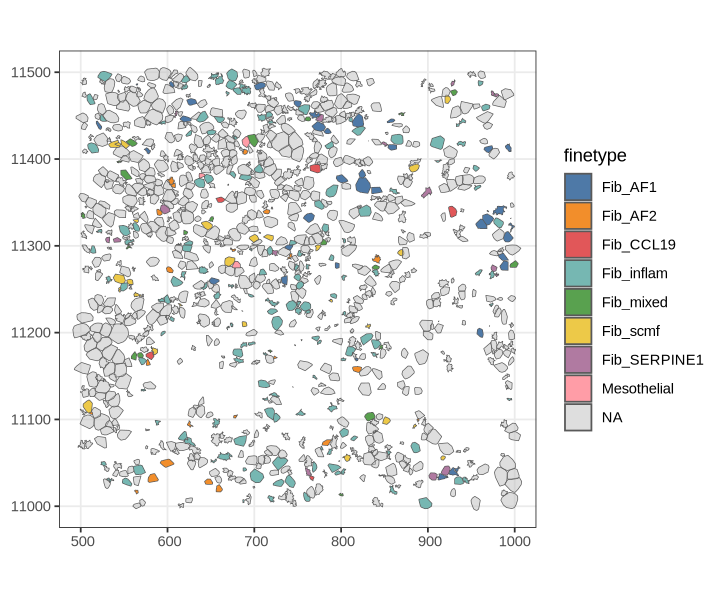

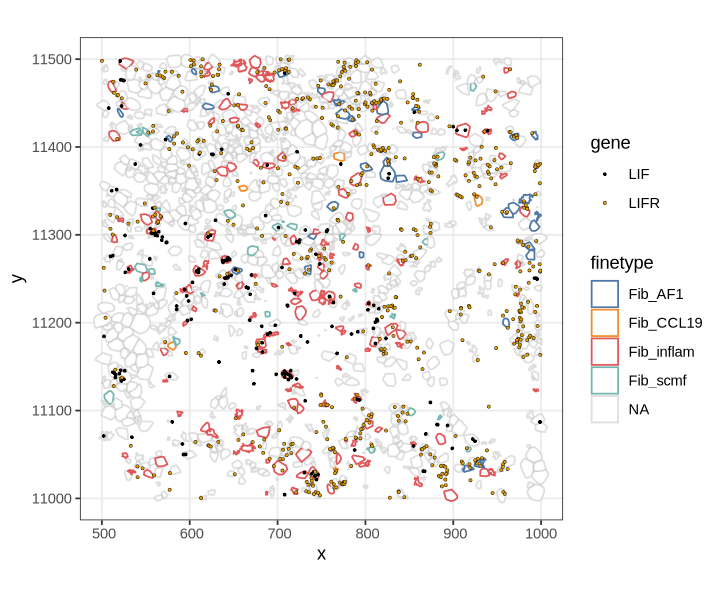

In [19]:
# Medium magnification plots of coarse types in space, fine fibroblast types in space, selected fibroblast types in space with LIF/LIFR Tx overlay. 
fig.size(5,6)
xlims <- c(500,1000)
ylims <- c(11000, 11500)

p1 <- bs13_tess_shapes %>%
    filter(between(X,xlims[1], xlims[2])) %>%
    filter(between(Y,ylims[1], ylims[2])) %>%
    ggplot() +
        geom_sf(aes(geometry = geometry, fill =coarse_ids))+
        xlim(xlims) +
        ylim(ylims) +
        theme_bw() +
        coord_sf()+
        scale_fill_tableau(palette= "Tableau 10", name = "coarsetype")+
        NULL
p1

p2 <- bs13_tess_shapes %>%
    filter(between(X,xlims[1], xlims[2])) %>%
    filter(between(Y,ylims[1], ylims[2])) %>%
    mutate(merged_fine_ids = if_else(coarse_ids == "Fibroblast", merged_fine_ids, NA)) %>%
    ggplot() +
        geom_sf(aes(geometry = geometry, fill =merged_fine_ids))+
        xlim(xlims) +
        ylim(ylims) +
        theme_bw() +
        coord_sf()+
        scale_fill_tableau(palette= "Tableau 10", na.value = alpha("grey", 0.5), name = "finetype")+
        NULL
p2

p3 <- bs13_tess_shapes %>%
    filter(between(X,xlims[1], xlims[2])) %>%
    filter(between(Y,ylims[1], ylims[2])) %>%
    mutate(merged_fine_ids = if_else(merged_fine_ids %in% c("Fib_inflam", "Fib_scmf", "Fib_AF1", "Fib_CCL19"), merged_fine_ids, NA)) %>%
    ggplot() +
        geom_sf(aes(geometry = geometry, col =merged_fine_ids), fill = "white", linewidth = 0.5)+
        geom_point(data = tx_filt, aes(x, y, fill= gene), size = 0.8, shape = 21, stroke= 0.2)+
        xlim(xlims) +
        ylim(ylims) +
        theme_bw() +
        coord_sf()+
        scale_color_tableau(palette= "Tableau 10", na.value = alpha("grey", 0.5), name = "finetype")+
        scale_fill_colorblind()+
        NULL
p3

NULL

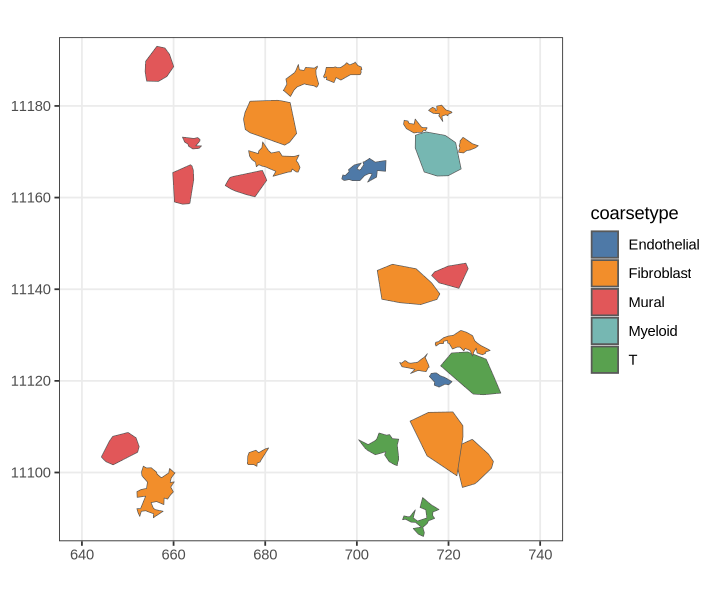

Warning message:
“Removed 10689 rows containing missing values or values outside the scale range
(`geom_point()`).”


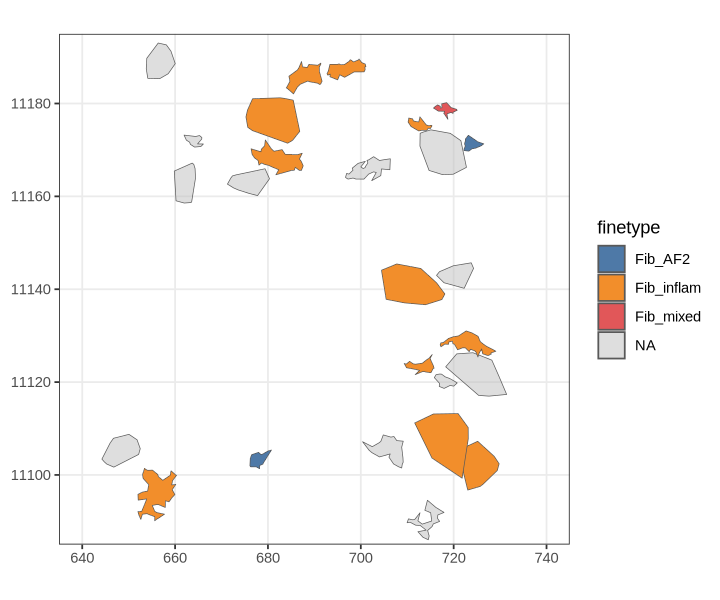

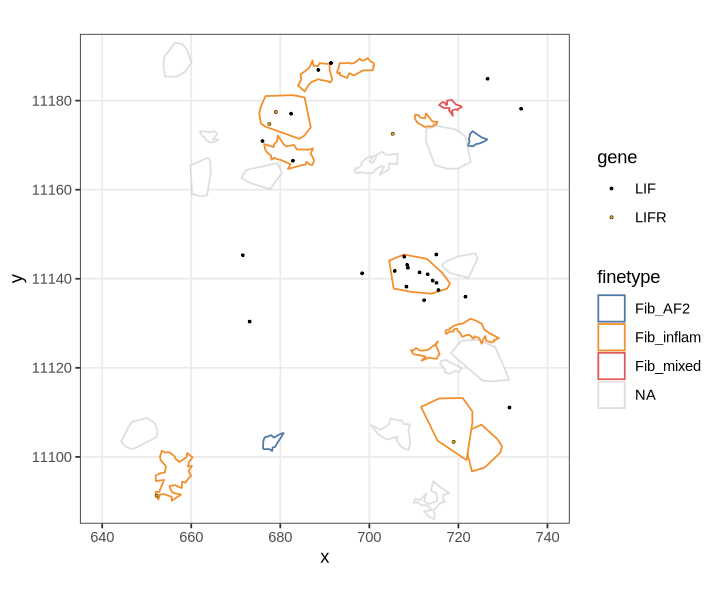

In [20]:
# High magnification plots of coarse types in space, fine fibroblast types in space, selected fibroblast types in space with LIF/LIFR Tx overlay. 
fig.size(5,6)
xlims <- c(640,740)
ylims <- c(11090, 11190)

p1 <- bs13_tess_shapes %>%
    filter(between(X,xlims[1], xlims[2])) %>%
    filter(between(Y,ylims[1], ylims[2])) %>%
    ggplot() +
        geom_sf(aes(geometry = geometry, fill =coarse_ids))+
        xlim(xlims) +
        ylim(ylims) +
        theme_bw() +
        coord_sf()+
        scale_fill_tableau(palette= "Tableau 10", name = "coarsetype")+
        NULL
p1

p2 <- bs13_tess_shapes %>%
    filter(between(X,xlims[1], xlims[2])) %>%
    filter(between(Y,ylims[1], ylims[2])) %>%
    mutate(merged_fine_ids = if_else(coarse_ids == "Fibroblast", merged_fine_ids, NA)) %>%
    ggplot() +
        geom_sf(aes(geometry = geometry, fill =merged_fine_ids))+
        xlim(xlims) +
        ylim(ylims) +
        theme_bw() +
        coord_sf()+
        scale_fill_tableau(palette= "Tableau 10", na.value = alpha("grey", 0.5), name = "finetype")+
        NULL
p2

p3 <- bs13_tess_shapes %>%
    filter(between(X,xlims[1], xlims[2])) %>%
    filter(between(Y,ylims[1], ylims[2])) %>%
    mutate(merged_fine_ids = if_else(coarse_ids == "Fibroblast", merged_fine_ids, NA)) %>%
    ggplot() +
        geom_sf(aes(geometry = geometry, col =merged_fine_ids), fill = "white", linewidth = 0.5)+
        geom_point(data = tx_filt, aes(x, y, fill= gene), size = 0.8, shape = 21, stroke= 0.2)+
        xlim(xlims) +
        ylim(ylims) +
        theme_bw() +
        coord_sf()+
        scale_color_tableau(palette= "Tableau 10", na.value = alpha("grey", 0.5), name = "finetype")+
        scale_fill_colorblind()+
        NULL
p3

## Extended data figure 1A. Heatmap of marker genes for coarse spatial niches.

In [41]:
# Calculate glm marker genes for coarse niche types
all_markers_niche <- get_markers(counts = tess@assays$RNA$counts, 
                              meta_data = tess@meta.data,
                              cluster_colname = "coarse_niche_type",
                              sample_colname = "tissue"
                            )

CAREFUL: get_norm makes very strong assumptions about data

CAUTION: if using GLMM, make sure your counts are integers!

Joining with `by = join_by(grpvar_orig)`


[1] 33.237


NULL

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


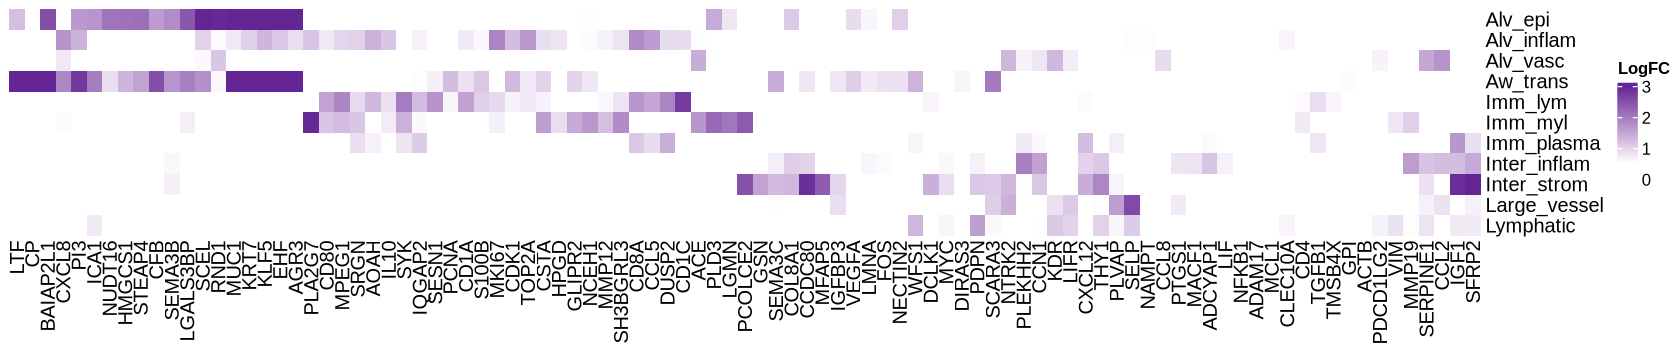

In [44]:
# Select top 10 features per niche type for heatmap
feats_niche <- all_markers_niche %>% 
    filter() %>%
    arrange(zscore) %>%
    group_by(cluster) %>%
    slice(1:10) %>%
    pull(feature)

# Plot heatmap
fig.size(3,14)
all_markers_niche %>% 
    filter(feature %in% c(feats_niche, "LIF", "LIFR")) %>%
    arrange(cluster) %>%
    dplyr::select(cluster, feature, logFC) %>%
    pivot_wider(names_from = feature, values_from = logFC) %>%
    column_to_rownames("cluster") %>%
    Heatmap(cluster_rows = F,
            col = colorRamp2(c(0,0.5, 3),c("white" , "white",muted("purple"))), 
            name = "LogFC",
            cluster_columns = T,
            show_column_dend = F
           )

## Extended data figure 1B. Heatmap of marker cell states for coarse spatial niches.

In [47]:
# Prepare inputs for per niche type cell type markers

# Per niche cell type counts matrix
ct_cts <- tess_pts %>%
    group_by(tissue_agg_id) %>%
    count(merged_fine_ids) %>%
    pivot_wider(names_from = merged_fine_ids, values_from = n, values_fill = 0) %>%
    column_to_rownames("tissue_agg_id")

# Per niche meta data (niche type, tissue).
ct_meta <- tess_pts %>%
    dplyr::select(tissue_agg_id, coarse_niche_type, fine_niche_type, tissue) %>%
    unique() %>%
    column_to_rownames("tissue_agg_id")

In [48]:
# Calculate cell type markers for niche types
all_markers_ct_niche <- get_markers(counts = t(ct_cts[rownames(ct_meta),]), 
                              meta_data = ct_meta,
                              cluster_colname = "fine_niche_type",
                              sample_colname = "tissue"
                            )

CAREFUL: get_norm makes very strong assumptions about data

CAUTION: if using GLMM, make sure your counts are integers!

Joining with `by = join_by(grpvar_orig)`


[1] 14.981


NULL

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


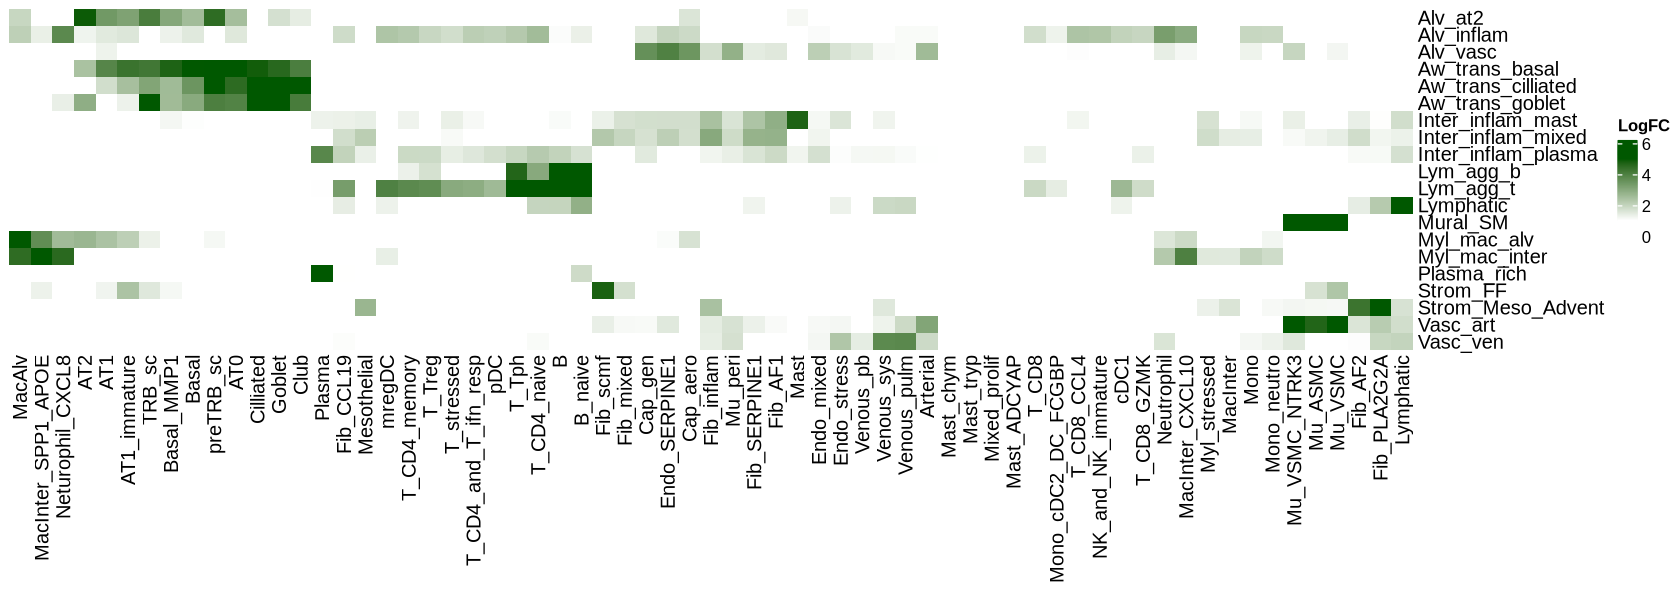

In [50]:
# Plot heatmap
fig.size(5,14)
all_markers_ct_niche %>% 
    arrange(cluster) %>%
    dplyr::select(cluster, feature, logFC) %>%
    pivot_wider(names_from = feature, values_from = logFC) %>%
    column_to_rownames("cluster") %>%
    Heatmap(cluster_rows = F,
            col = colorRamp2(c(0,1, 5), c("white" , "white",muted("green"))), 
            name = "LogFC",
            cluster_columns = T,
            show_column_dend = F
           )